<a href="https://colab.research.google.com/github/philongbuile/houseprice_prediction/blob/main/UK_HousePricePrediction_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


# Dataset
Our main data set is the UK Land Registry’s ‘sold’ data set for November 2022, which contains the house transactions for last month, including each property’s address, type, and price.

We are only interested in the price, postcode, the property type (D - Detached, S - Semi, F - Flat, T - Terraced, O - Other) and whether it is a new build or not (Y/N). We are not interested in month to month and neither year to year trends.

In [ ]:
# sheet_id = "11JpITAHwiBWJekj8I9ABVCh4kCqTUwMtzZQBbpXg6Vc"
# sheet_name = "pp-monthly-update-new-version"

url='https://drive.google.com/file/d/12Tc0XT9wkeK6LGRGW3aG6vpt38e5of7y/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
house_prices_df = pd.read_csv(path,
                              usecols=[1,3,4,5],
                              names=["price","postcode","type","new"])
house_prices_df.head()


,price,postcode,type,new
0,190000,W14 9HQ,F,N
1,685000,SL5 9TB,D,N
2,95000,SS4 1FF,F,N
3,915000,AL4 0FR,D,N
4,105000,DN15 9JF,D,N


# Postcode to Latitude and Longtitude
The next data set is a mapping of postcodes to geographical coordinates, in the form of (postcode, latitude, longitude) tuples.

In [ ]:
url='https://drive.google.com/file/d/1O2Kl6IjUju4t5rZoh-URLMjREDWZNT_U/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
postcodes_df = pd.read_csv(path,usecols=[1,2,3])
postcodes_df.head()


,postcode,latitude,longitude
0,AB10 1XG,57.144156,-2.114864
1,AB10 6RN,57.137871,-2.121487
2,AB10 7JB,57.124274,-2.127206
3,AB11 5QN,57.142701,-2.093295
4,AB11 6UL,57.137468,-2.112455


In [ ]:
df = house_prices_df.merge(postcodes_df,how='inner',left_on='postcode',right_on='postcode')
df['price'] = df['price'] / 1000
df.head()


,price,postcode,type,new,latitude,longitude
0,190.0,W14 9HQ,F,N,51.489344,-0.207948
1,222.5,W14 9HQ,F,N,51.489344,-0.207948
2,499.7,W14 9HQ,F,N,51.489344,-0.207948
3,685.0,SL5 9TB,D,N,51.398329,-0.656109
4,95.0,SS4 1FF,F,N,51.584299,0.700113


In [ ]:
df['price'].describe()


count    111629.000000
mean        387.520983
std        1129.946695
min           0.100000
25%         175.000000
50%         275.000000
75%         425.000000
max      165000.000000
Name: price, dtype: float64

# Visualize

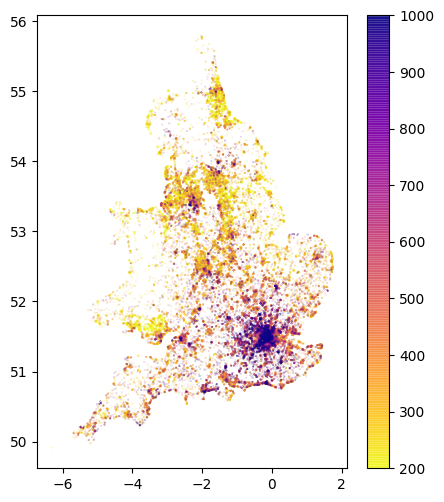

In [ ]:
def visualise(df, vmin, vmax):
    
    df_sorted = df.sort_values(by='price')
    x = df_sorted['longitude']
    y = df_sorted['latitude']
    c = df_sorted['price'] 

    plt.rcParams['figure.figsize'] = [5, 6]
    plt.rcParams['figure.dpi'] = 100 

    plt.scatter(x, y, s=0.01, c=c, cmap='plasma_r', 
                norm=colors.Normalize(vmin=vmin,vmax=vmax), alpha=0.8)
    plt.colorbar()
    plt.show()
    
visualise(df, 200, 1000)


# House Price Prediction by Location

In [ ]:
# Terraced houses only (i.e., Townhouses in the US)
prices_df = df[(df['type'] == 'T')]
# Obtain the average price paid in each postcode
prices_df = prices_df.groupby(["postcode","latitude","longitude"], as_index=False)["price"].mean()
prices_df.head()


,postcode,latitude,longitude,price
0,AL1 1NE,51.749181,-0.337350,685.0
1,AL1 1PG,51.747633,-0.332786,685.0
2,AL1 1RQ,51.747810,-0.338313,640.0
3,AL1 1UU,51.736220,-0.311844,480.0
4,AL1 2JT,51.739646,-0.340915,665.5


# using K-NN
Our first model is k-Nearest Neighbors (k-NN). In particular, KNeighborsRegressor from SciKit-Learn, given that prices are continous values.

Let us start by splitting the data set into training and test sets.

In [ ]:
X = prices_df[['latitude','longitude']]
y = prices_df['price']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)



k-NN isn’t hands off. We need to make an assumption about what is the most optimal number of neighbours (the hyperparameter k), as well as to whether the distance of each neighbour should be uniform, or otherwise; in other words, the hyperparameter weights. One way to find out is by brute force, that is to say, by trying different values, as follows:

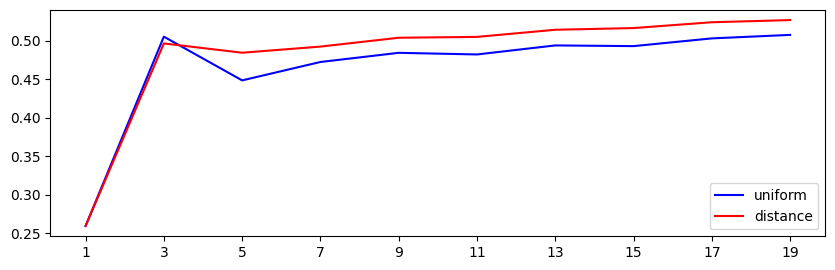

In [ ]:
uniform  = []
distance = []
r = range (1,21,2)

for k in r:
    
    # Euclidan, 'straight' distance
    model = KNeighborsRegressor(n_neighbors = k, weights='uniform')
    model.fit(X_train.values, y_train.values)
    uniform.append(model.score(X_test.values,y_test.values))

    # Distance is inversely proportional (to lessen the weight of outliers)
    model = KNeighborsRegressor(n_neighbors = k, weights='distance') 
    model.fit(X_train.values, y_train.values)
    distance.append(model.score(X_test.values,y_test.values))

uniform = np.array(uniform)
distance = np.array(distance)

plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.plot(r,uniform,label='uniform',color='blue')
plt.plot(r,distance,label='distance',color='red')
plt.legend()
plt.gca().set_xticks(r)
plt.show()


The results suggest that using the hyperparameters k = 17, and weight='distance' would provide the most accuracy.

In [ ]:
pd.DataFrame({"k" : r, "uniform" : uniform, "distance" : distance})


,k,uniform,distance
0,1,0.259308,0.259308
1,3,0.505164,0.496355
2,5,0.448395,0.484320
3,7,0.472274,0.492271
4,9,0.484183,0.503766
5,11,0.482060,0.504865
6,13,0.493794,0.514131
7,15,0.492889,0.516335
8,17,0.502925,0.523888
9,19,0.507466,0.526710


This process, though, is tedious and makes rigid assumptions about the training data set. A way of further shuffling the training data set is through a process called cross-validation. The GridSearchCV function combines both the ability to define the number of splits and iterate through various hyperparameters.

In our case, rather than defining the convoluted loop seen a above, we simply specify the range of values we want to try out:

In [ ]:
params = {'n_neighbors':range(1,21,2),'weights':['uniform','distance']}


The next step is to pass the k-NN instance, our parameters (param) bundle, and number of splits (cv=5) to GridSearchCV:

In [ ]:
model = GridSearchCV(KNeighborsRegressor(), params, cv=5)
model.fit(X_train.values,y_train.values)
model.best_params_


{'n_neighbors': 17, 'weights': 'uniform'}

In [ ]:
model.score(X_test.values,y_test.values)

0.5029246636893736

In [ ]:
predictions = model.predict(X_test)
print(predictions)

[191.05488235  96.44085294 852.99735294 ... 122.46176471 468.93823529
 537.88235294]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


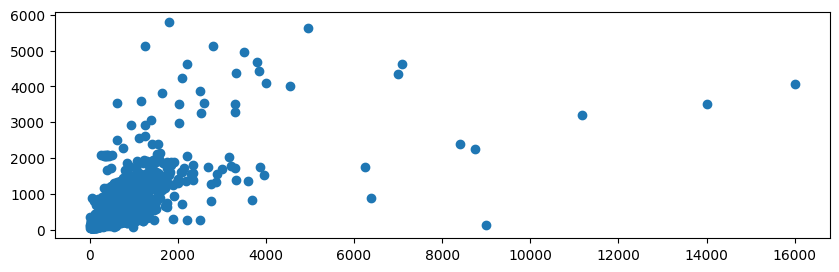

In [ ]:
plt.scatter(y_test,predictions)

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print(metrics.explained_variance_score(y_test, predictions))

MAE: 86.86459199001997
MSE: 83974.3665973202
RMSE: 289.7833097287009
0.5029743955482293


In [ ]:
import cufflinks as cf 
cf.go_offline()
import plotly.io as pio
pio.renderers.default = "colab"
pd.DataFrame({"Predicted price":predictions, "Original price": y_test}).iplot(mode="markers")

In [ ]:
def price(description,lat,lon):
    features = [[lat,lon]]
    print("{:30s} -> {:5.0f}k ".format(description,float(model.predict(features))))

# Examples
price('Oxford Circus, London', 51.515276, -0.142038)
price('Harrods (B. Road), London', 51.499814, -0.163366)
price('Peak District, National Park', 53.328508, -1.783416)


Oxford Circus, London          ->  4140k 
Harrods (B. Road), London      ->  5003k 
Peak District, National Park   ->   199k 
